# A. Wave analysis - Majuro Atoll (Republic of the Marshall Islands)

## Short-term Statistics

In [1]:
# os
import os
import os.path as op
import sys

# arrays
import math
import numpy as np
import pandas as pd
from scipy import signal as sg

# plot
import matplotlib.pyplot as plt

sys.path.insert(0, os.path.join(os.getcwd()  , '..', '..', '..'))

# dependencies
if(os.path.isdir('waves-main')): #thebe
    os.chdir('waves-main')
from lib.eta_spec import *

In [2]:
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter('ignore', np.RankWarning)

In [3]:
# path to data
if(os.path.isdir('data')):
    p_data = op.abspath(op.join(os.getcwd(), 'data', 'Majuro')) # thebe
else:
    p_data = op.abspath(op.join(os.getcwd(),'..', '..', '..', 'data', 'Majuro')) # notebook
    
p_pressure = op.join(p_data, 'Pressure')

For this study, 1-second data were collected from four pressure sensors deployed during the winter season of 2016-2017 (from mid-November until early February) by Murray Ford (University of Auckland). These pressure sensors were located in the lagoon as shown in the figure bellow; sensors 41320 (tidal gauge) and 41323 were placed closely at the east-side lagoon shoreline, 41321 is situated in the middle of the lagoon and 41322 in front of the shipping channel

### 1. Load data


In [4]:
# Murray sensors  -->  sea pressure (1-sec data)
#xds_41320p = xr.open_dataset(p_pressure + '/Data_41320_pressure')
xds_41321p = xr.open_dataset(p_pressure + '/Data_41321_pressure')
#xds_41322p = xr.open_dataset(p_pressure + '/Data_41322_pressure')
#xds_41323p = xr.open_dataset(p_pressure + '/Data_41323_pressure')


In [5]:
sensor = xds_41321p

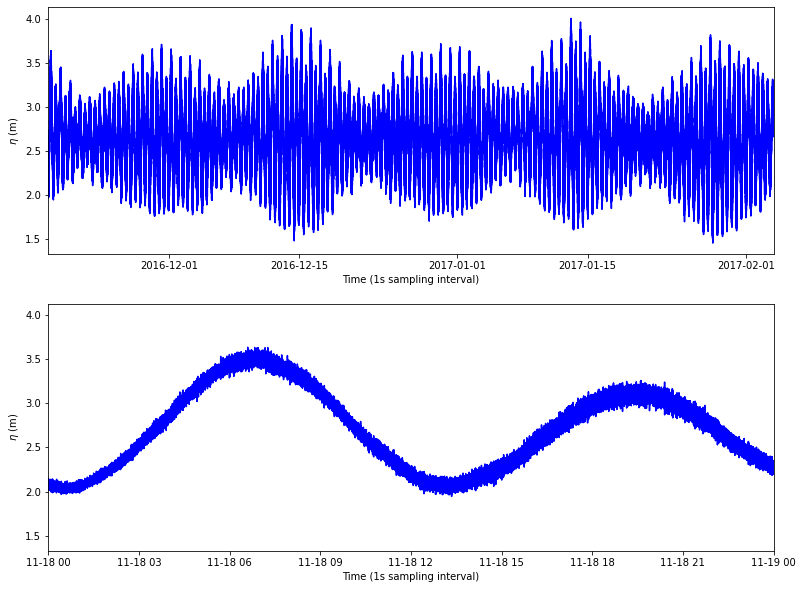

In [6]:
fig, axs = plt.subplots(2, 1, figsize=(13,10))
axs[0].plot(sensor.time, sensor.Depth, color='b')
axs[1].plot(sensor.time, sensor.Depth, color='b')

axs[0].set_xlabel('Time (1s sampling interval)')
axs[0].set_ylabel('$\eta$ (m)')

axs[1].set_xlabel('Time (1s sampling interval)')
axs[1].set_ylabel('$\eta$ (m)')

axs[0].set_xlim([sensor.time.values[0], sensor.time.values[-1]])
axs[1].set_xlim([np.datetime64('2016-11-18T00:00:00'), np.datetime64('2016-11-19T00:00:00')])
plt.show()

In [7]:
print("Mean:              ", np.mean(sensor.Depth.values))
print("Standar Deviation: ", np.var(sensor.Depth.values))

Mean:               2.6380446707445464
Standar Deviation:  0.185952843311758


### 2. Hourly Running-mean to delete tide 

In [8]:
running = sensor.Depth.to_dataframe().rolling(window=3600).mean()
series = sensor.Depth.values - running.values.reshape(-1)

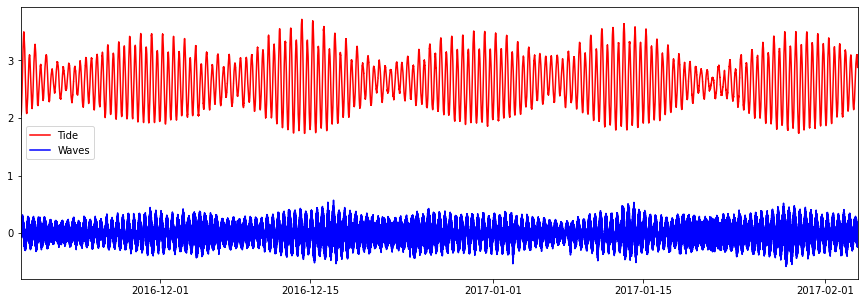

In [9]:
plt.figure(figsize=(15,5))
plt.plot(sensor.time, running.values.reshape(-1), c='r', label='Tide')
plt.plot(sensor.time, series, c='b', label='Waves')
plt.xlim([sensor.time.values[0], sensor.time.values[-1]])
plt.legend()
plt.show()

## Spectra analysis

### 3.1 Select sea-state

In [10]:
# create pandas DataFrame, delete nans and round to hour
df_waves = pd.DataFrame({'Depth':series}, index=sensor.time)
df_waves.dropna(inplace=True)
df_waves.index = df_waves.index.round('1s')  

In [11]:
start_date = '2016-12-15T01:00:00'
end_date = '2016-12-15T02:00:00' 

df_subw = df_waves.loc[(df_waves.index > start_date) & (df_waves.index < end_date)] 

### 3.2 Compute wave spectra

In [12]:
# Calculate spectra help(sg.welch)
f, E = sg.welch(df_subw.values.reshape(-1), fs = 1, nfft=1024)

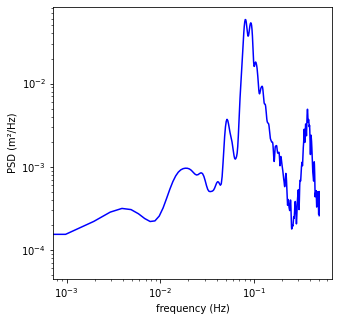

In [13]:
# Plot wave spectrum
plt.figure(figsize=(5,5))
plt.loglog(f, E, c='b')
plt.xlabel('frequency (Hz)')
plt.ylabel('Densidad espectral (/Hz)')
plt.ylabel('PSD (m²/Hz)')
plt.show()

In [14]:
print('Peak frequency: ' + str(f[np.argmax(E)]))
print('Peak period:    ' + str(1/f[np.argmax(E)]))

Peak frequency: 0.0810546875
Peak period:    12.337349397590362


### 3.3 Select short-waves

In [15]:
# Eliminate lowest-frequency spectral energy
Es = E[np.where(f > (1/30))[0]]
fs = f[np.where(f > (1/30))[0]]

Ei = E[np.where((f > (1/(5*60))) & (f < (1/30)))[0]]
fi = f[np.where((f > (1/(5*60))) & (f < (1/30)))[0]]

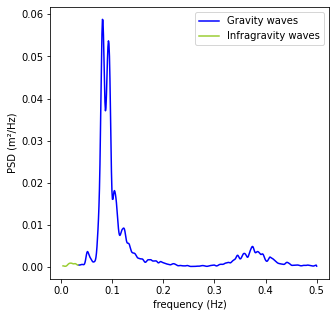

In [16]:
# Plot short-waves spectrum
plt.figure(figsize=(5,5))
plt.plot(fs, Es, c='b', label='Gravity waves', zorder=1)
plt.plot(fi, Ei, c='yellowgreen', label='Infragravity waves', zorder=2)

plt.xlabel('frequency (Hz)')
plt.ylabel('Densidad espectral (/Hz)')
plt.ylabel('PSD (m²/Hz)')
plt.legend()
plt.show()

In [17]:
print('Peak frequency: ' + str(fs[np.argmax(Es)]))
print('Peak period:    ' + str(1/fs[np.argmax(Es)]))

Peak frequency: 0.0810546875
Peak period:    12.337349397590362


### 3.4 JONSWAP Goda (1985)

$S(f)=\alpha\cdot H_{s}^{2} \cdot T_{p}^{-4} \cdot f^{-5} \cdot e^{-1.25 \cdot (T_{p} \cdot f)^{-4}} \cdot \gamma^{e^{-(T_{p} \cdot f - 1)^{2}/(2 \cdot \sigma^{2})}}$ 


$\alpha \approxeq \frac{0.0624}{0.230+0.0336 \cdot \gamma - 0.185 \cdot (1.9 + \gamma)^{-1}}$

$
\sigma=\begin{cases}
\sigma_{a};  f \leq f_{p} \\ \sigma_{b}; f \geq f_{p}
\end{cases}
$

$\gamma = 1 to 7 (mean 3.3), \sigma_{a}\approxeq0.07, \sigma_{b}\approxeq 0.09$

In [18]:
# from bimodal to unimodal spectra
Et = E[np.where(f < (0.25))[0]]
ft = f[np.where(f < (0.25))[0]]

In [19]:
gamma, EJon = assess_jonwsap(ft, Et)
print('Best gamma JONSWAP fit: ' + str(gamma))

Best gamma JONSWAP fit: 4


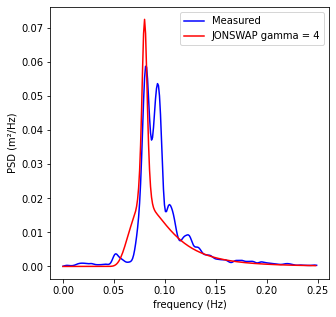

In [20]:
# Plot measured wave spectrum and theorecial JONSWAP shapes
plt.figure(figsize=(5,5))
plt.plot(ft, Et, c='b', label='Measured')
plt.plot(ft[:-1], EJon, c='r', label='JONSWAP gamma = {0}'.format(gamma))

plt.xlabel('frequency (Hz)')
plt.ylabel('Densidad espectral (/Hz)')
plt.ylabel('PSD (m²/Hz)')
plt.legend()
plt.show()

### 3.5. Inverse FFT

In [30]:
time = np.arange(0, len(df_subw.index), 1)
freqs = ft
delta_f = freqs[1] - freqs[0]
    
# series elevation
teta = np.zeros((len(time)))

# calculate aij
for f in range(len(freqs)):
    ai = np.sqrt(Et[f] * 2 * delta_f)
    eps = np.random.rand() * (2*np.pi)

    # calculate elevation
    teta = teta + ai * np.cos(2*np.pi*freqs[f] * time + eps)

# generate series dataframe
series = pd.DataFrame({'eta':teta}, index=df_subw.index)


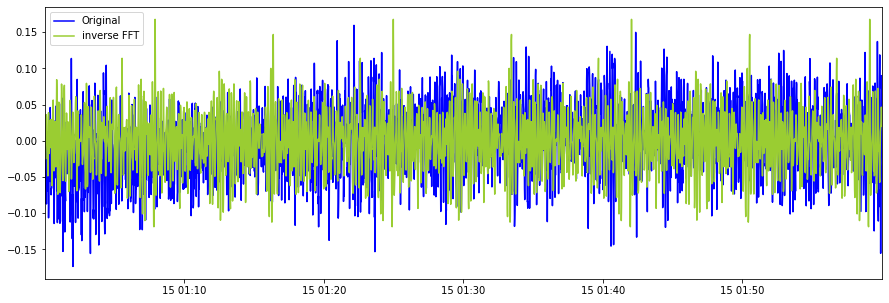

In [81]:
plt.figure(figsize=(15,5))
plt.plot(df_subw.index, df_subw.values.reshape(-1)-np.nanmean(df_subw.values.reshape(-1)), c='b', label='Original')
plt.plot(series.index, series['eta'], c='yellowgreen', label='inverse FFT')
plt.xlim([df_subw.index.values[0], df_subw.index.values[-1]])
plt.legend()
plt.show()

In [32]:
# Calculate spectra help(sg.welch)
fo, Eo = sg.welch(series.values.reshape(-1), fs = 1, nfft=1024)

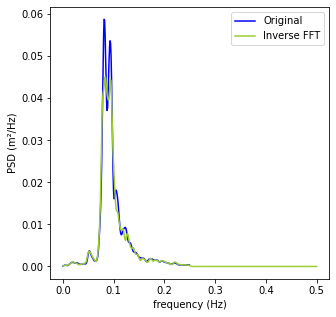

In [34]:
# Plot wave spectrum
plt.figure(figsize=(5,5))
plt.plot(ft, Et, c='b', label='Original')
plt.plot(fo, Eo, c='yellowgreen', label='Inverse FFT')
plt.xlabel('frequency (Hz)')
plt.ylabel('Densidad espectral (/Hz)')
plt.ylabel('PSD (m²/Hz)')
plt.legend()
plt.show()

## Statistical analysis

### 4.1 Upcrossing

In [35]:
samp = 1
T, H = upcrossing(df_subw.Depth.values, samp)

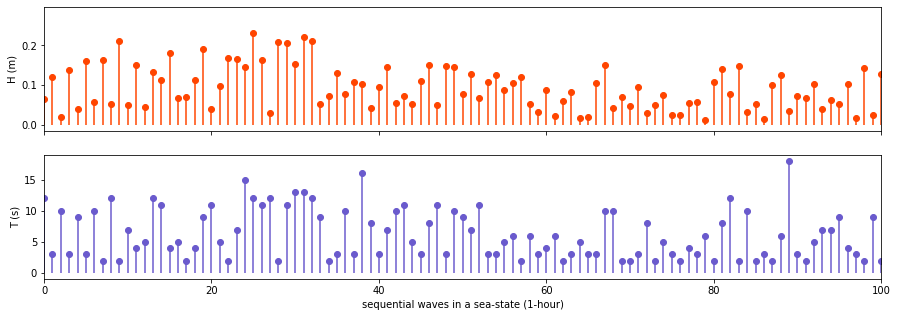

In [36]:
fig, axs = plt.subplots(2, 1, figsize=(15,5), sharex=True)
axs[0].vlines(range(len(H)), np.full(len(H), 0), H, color='orangered')
axs[1].vlines(range(len(T)), np.full(len(T), 0), T, color='slateblue')
axs[0].scatter(range(len(H)), H, color='orangered')
axs[1].scatter(range(len(T)), T, color='slateblue')

axs[0].set_ylabel('H (m)')
axs[1].set_ylabel('T (s)')
axs[1].set_xlabel('sequential waves in a sea-state (1-hour)')

plt.xlim(0, 100)
plt.show()

### 4.2 Statistical parameters

`mean wave heigh` $\overline H$

$\overline H = \frac{1}{N} \sum_{i=1}^{N} H_{i}$ <br> where i is the sequence number (in time) of the wave in the record

`root-mean-square wave height` $H_{rms}$

$H_{rms}=(\frac{1}{N} \sum_{i=1}^{N} H_{i}^{2})^{1/2}$

`significant wave heigh` $H_{1/3}$

$H_{1/3}=\frac{1}{N/3} \sum_{j=1}^{N/3} H_{j}$ <br> where j is the rank number of the wave, based on wave-heigh

`mean of the highest one-tenth of waves` $H_{1/10}$

$H_{1/10}=\frac{1}{N/10} \sum_{j=1}^{N/10} H_{j}$ 

`mean zero-crossing wave period` $\overline T_{0}$

$\overline T_{0}=\frac{1}{N} \sum_{i=1}^{N} T_{0,i}$

`significant wave period` $T_{1/3}$

$T_{1/3}=\frac{1}{N/3} \sum_{j=1}^{N/3} T_{0,j}$

In [37]:
# mean wave heigh
print("mean wave heigh:                        " + str(np.mean(H)))

# root-mean-square wave height
print("root-mean-square wave height:           " + str(rmsV(H)))

# significant wave heigh
print("significant wave heigh:                 " + str(highestN_stats(H, 3)))

# mean of the highest one-tenth of waves
print("mean of the highest one-tenth of waves: " + str(highestN_stats(H, 10)))

# maximun wave heigh
print("maximun wave heigh:                     " + str(np.max(H)))

# mean period
print("mean period:                            " + str(np.mean(T)))

# significant wave period
print("significant wave period:                " + str(highestN_stats(T, 3)))

# mean zero-crossing wave period
print("mean zero-crossing wave period:         " + str(highestN_stats(T, 10)))

# maximun wave period
print("maximun wave period:                    " + str(np.max(T)))

mean wave heigh:                        0.09682035689042863
root-mean-square wave height:           0.11222167673308499
significant wave heigh:                 0.1643645229557882
mean of the highest one-tenth of waves: 0.20959760408044653
maximun wave heigh:                     0.282703106184246
mean period:                            6.772296015180268
significant wave period:                10.960000000000033
mean zero-crossing wave period:         12.692307692307784
maximun wave period:                    18.0


### 4.3 Wave Heigh and Wave Period Distributions

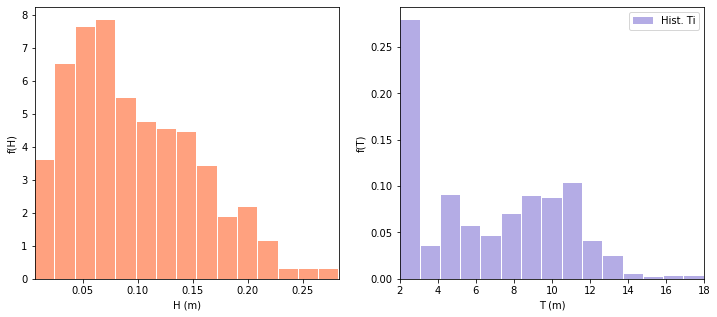

In [28]:
# Plot - sort arrays
fig, axs = plt.subplots(1, 2, figsize=(12,5))
axs[0].hist(H, density = True, bins = 15, rwidth=0.95, color = "orangered", alpha=0.5, label='Hist. Hi')
axs[1].hist(T, density=True, bins=15, rwidth=0.95, color = "slateblue", alpha=0.5, label='Hist. Ti')

axs[0].set_xlabel('H (m)')
axs[0].set_ylabel('f(H)')
axs[1].set_xlabel('T (m)')
axs[1].set_ylabel('f(T)')

axs[0].set_xlim(np.nanmin(H), np.nanmax(H))
axs[1].set_xlim(np.nanmin(T), np.nanmax(T))
axs[1].legend()
axs[0].legend()
plt.show()

## Statistical parameters for the entire record (2016-11-18 00:59:59 - 2017-02-03 23:59:59)

In [55]:
date0 = df_waves.index.values[0]
date1 = df_waves.index.values[-1]

start_d = datetime.datetime(year=df_waves.index.year[0], month=df_waves.index.month[0], day=df_waves.index.day[0], hour=df_waves.index.hour[0])
end_d = datetime.datetime(year=df_waves.index.year[-1], month=df_waves.index.month[-1], day=df_waves.index.day[-1], hour=df_waves.index.hour[-1])

times = np.arange(start_d, end_d, datetime.timedelta(hours=1))


In [75]:
Hs, Tm = [], []
for pintv, intv in enumerate(times[:-1]):
    sys.stdout.write('Sea-state {0} from {1}\r'.format(pintv, len(times)))
    sys.stdout.flush()
    
    df_sub = df_waves.loc[(df_waves.index > times[pintv]) & (df_waves.index < times[pintv + 1])]
    
    T, H = upcrossing(df_sub.Depth.values, samp)
    Hs.append(highestN_stats(H, 3))
    Tm.append(np.mean(T))

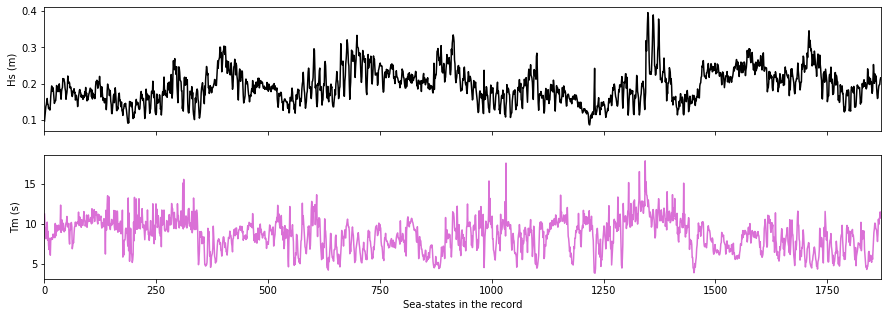

In [80]:
# Plot
fig, axs = plt.subplots(2, 1, figsize=(15,5), sharex=True)
axs[0].plot(range(len(Hs)),  Hs, color='k')
axs[1].plot(range(len(Tm)), Tm, color='orchid')

axs[0].set_ylabel('Hs (m)')
axs[1].set_ylabel('Tm (s)')
axs[1].set_xlabel('Sea-states in the record')

plt.xlim(0, len(Hs))
plt.show()